## Generative models should preserve relative distances from input to latent to generated space
- Read in model and some n input images
- Using L1 (others later), find distance between image pairs
- Transform to latent space and output space, again measuring L1 at both stages
- Do analysis

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning
from pytorch_lightning import Trainer
from dataloader import Dataset
import os
import vae
from model import Model
import simplejson 
import math
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage as pil
from torchvision.utils import make_grid
from PIL import Image
from IPython.display import display

In [2]:
exs = [
    '/home/sonia/generative-models/logs/dists/mnist/vae/version_0',
    '/home/sonia/generative-models/logs/dists/gtsrb/vae/version_0',
    '/home/sonia/generative-models/logs/dists/coloredMNIST/betavae/version_0', #128 latent dims
    '/home/sonia/generative-models/logs/dists/coloredMNIST/betavae/version_1', #32 latent dims
    '/home/sonia/generative-models/logs/dists/coloredMNIST/betavae/version_2', #8 latent dims
]

In [23]:
path_to_model = exs[2]
n = 100

### Setup
#### Read in model

In [24]:
modelconfig = simplejson.load(open(os.path.join(path_to_model, 'modelconfig.json')))
dataconfig = simplejson.load(open(os.path.join(path_to_model, 'dataconfig.json')))
checkpoint = os.path.join(path_to_model, 'checkpoints/last.ckpt')
model = vae.vanilla_vae(**modelconfig['model_params']).cuda()

In [25]:
# declaring these objects initializes some important things that cause images to look correct - do not remove
experiment = Model(model.cuda(), modelconfig['exp_params']).cuda()
e=experiment.load_from_checkpoint(checkpoint, model=model, params=modelconfig['exp_params'])
trainer = Trainer(gpus=[0])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Read in data

In [6]:
data = Dataset(**dataconfig, pin_memory=True)#use GPU
data.setup()
val = data.val_dataset

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [7]:
#choose random subset of n samples
randy = torch.rand(size=(len(val), ))
indices = [i.item() for i in torch.topk(randy, n)[1]] #actual index numbers
inputdata = torch.utils.data.Subset(val, indices)
input = DataLoader(inputdata, 
                    batch_size=dataconfig['val_batch_size'],
                    num_workers=dataconfig['num_workers'],
                    shuffle=False,
                    pin_memory=True)

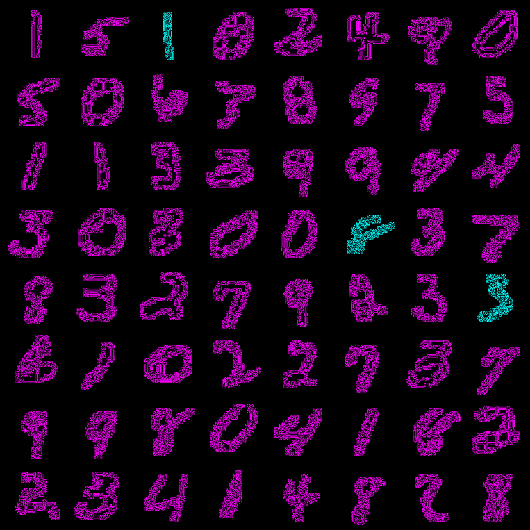

In [12]:
batch=next(iter(input))
imgs = batch[0]
pil()(make_grid(imgs, nrow=int(imgs.shape[0]**0.5)))
# to get index: the top row has indices 0, 1, 2, etc

In [21]:
index = 2 # which image in the batch that you want to look at
factor = 50 #how far from mean to move, ie e^factor

### Evaluate

#### (Optional) run on all train and validation data to compare metrics

In [9]:
# val dataset
# trainer.test(model=experiment, dataloaders=data.val_dataloader())

In [10]:
# train dataset
# trainer.test(model=experiment, dataloaders=data.train_dataloader())

#### Transform to latent and output spaces

In [11]:
# for visualization
def normalize(v):
    v = v-v.min()
    v = v/v.max()
    return v

In [26]:
# for distribution graphs
o = []
i = []
mu = []
logvar = []
model=model.cuda()

In [27]:
for b, x in input:
    res = model.forward(b.cuda())
    logvar.append(res[3])
    i.append(b)
    mu.append(res[2])
    o.append(res[0])

In [28]:
o=torch.cat(o).cpu().detach().numpy()
i=torch.cat(i).cpu().detach().numpy()
mu = torch.cat(mu).cpu().detach().numpy()
logvar = torch.cat(logvar).cpu().detach().numpy()
var = math.e**logvar

https://stackoverflow.com/questions/23186804/graph-point-on-straight-line-number-line-in-python

In [29]:
def graph(mu, var):
    # set up the figure
    upper = (mu+var**.5).max() + 0.01
    lower = (mu-var**.5).min() - 0.01
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(lower, upper)
    ax.set_ylim(0,10)

    # draw lines
    xmin = lower
    xmax = upper
    y = 5
    height = 1

    plt.hlines(y, xmin, xmax)
    plt.vlines(xmin, y - height / 2., y + height / 2.)
    plt.vlines(xmax, y - height / 2., y + height / 2.)
    plt.text(xmin, y-1, '%.2f'%lower, horizontalalignment='left')
    plt.text(xmax, y-1, '%.2f'%upper, horizontalalignment='right')
    if lower < 0 and upper > 0:
        plt.vlines(0, y - height / 2., y + height / 2.)
        plt.text(0, y-1, '0', horizontalalignment='center')

    for i in range(len(mu)):
        plt.plot(mu[i], y, 'go', ms = 20*var[i]**.5, mfc = 'g', alpha=0.5)

    plt.axis('off')
    plt.show()

NOTE: The standard deviations aren't to-scale relative to the rest of the graph, only to each other. This is an issue of matplotlib, will probably need to revisit later.

0
Dimension 0 	mean 0.03 	var 0.75


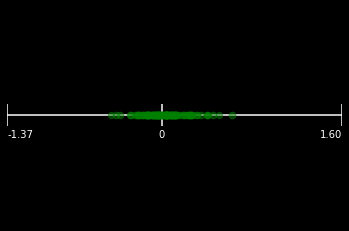

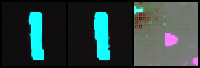

1
Dimension 1 	mean -0.01 	var 0.79


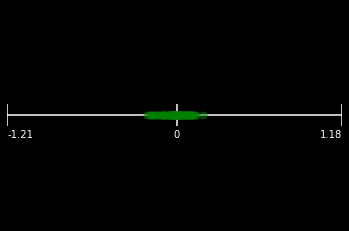

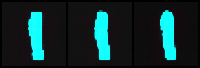

2
Dimension 2 	mean -0.00 	var 0.78


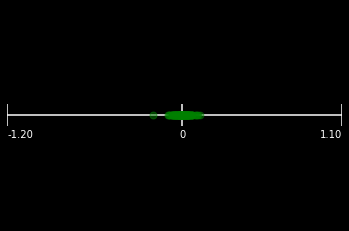

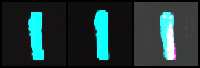

3
Dimension 3 	mean -0.01 	var 0.78


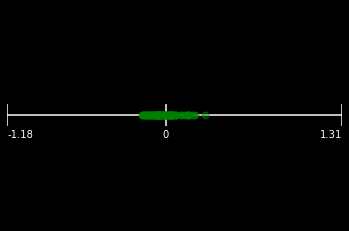

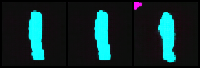

4
Dimension 4 	mean -0.02 	var 0.78


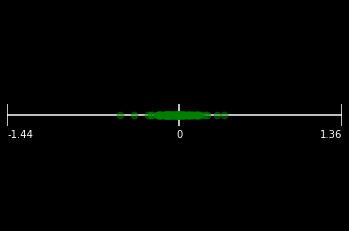

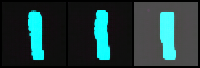

5
Dimension 5 	mean -0.02 	var 0.79


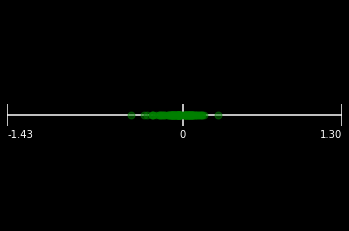

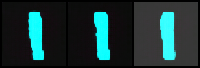

6
Dimension 6 	mean 0.01 	var 0.88


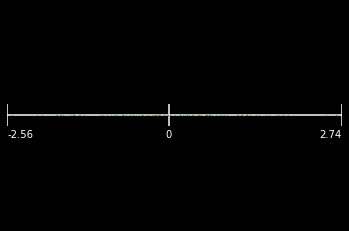

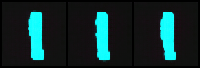

7
Dimension 7 	mean -0.01 	var 0.75


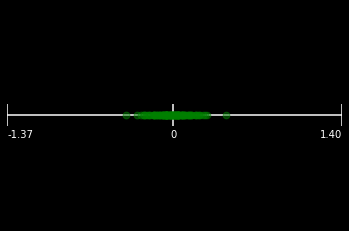

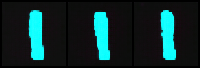

8
Dimension 8 	mean -0.01 	var 0.78


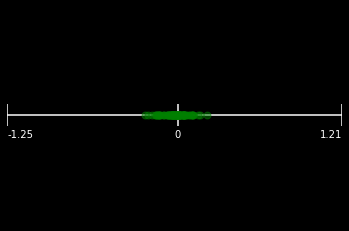

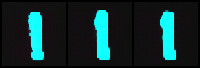

9
Dimension 9 	mean -0.02 	var 0.75


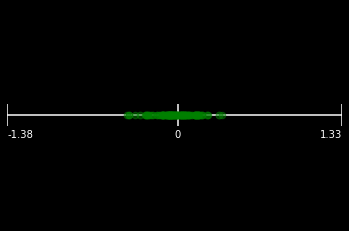

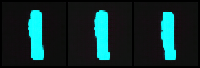

10
Dimension 10 	mean -0.01 	var 0.81


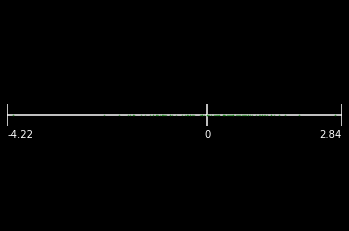

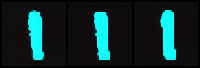

11
Dimension 11 	mean 0.03 	var 0.76


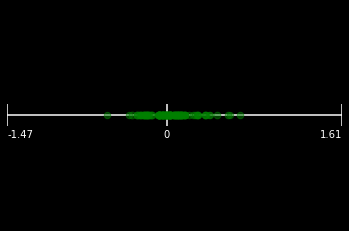

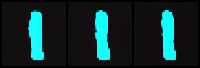

12
Dimension 12 	mean 0.01 	var 0.77


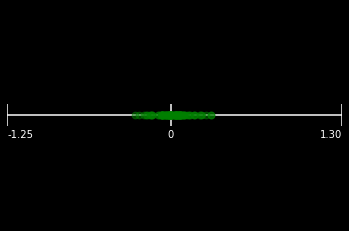

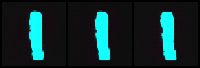

13
Dimension 13 	mean -0.06 	var 0.68


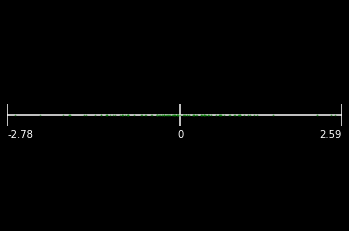

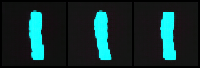

14
Dimension 14 	mean 0.00 	var 0.79


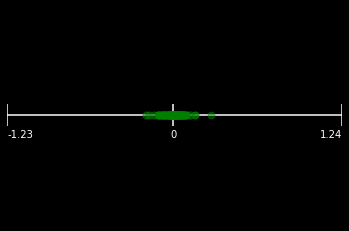

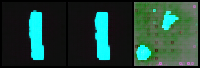

15
Dimension 15 	mean 0.00 	var 0.78


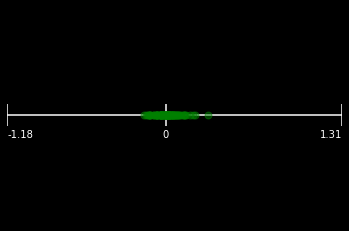

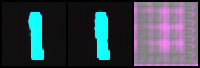

16
Dimension 16 	mean 0.02 	var 0.77


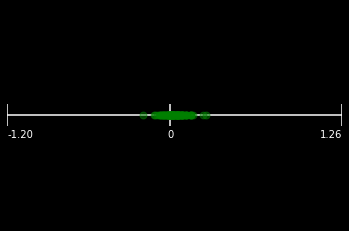

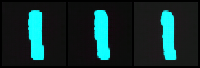

17
Dimension 17 	mean -0.01 	var 0.78


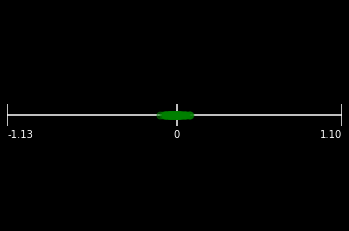

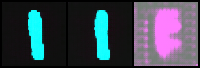

18
Dimension 18 	mean -0.02 	var 0.78


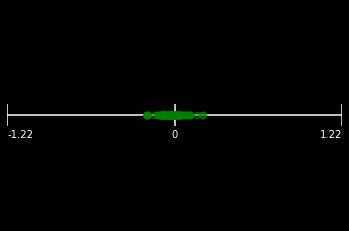

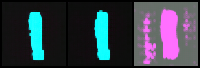

19
Dimension 19 	mean 0.03 	var 0.77


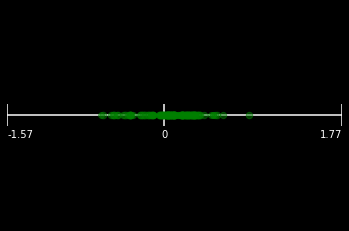

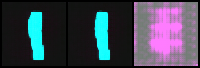

20
Dimension 20 	mean 0.02 	var 0.79


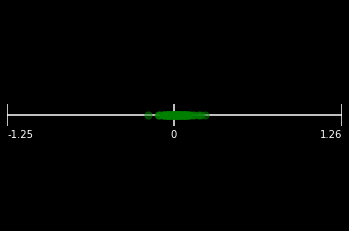

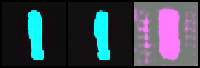

21
Dimension 21 	mean -0.01 	var 0.78


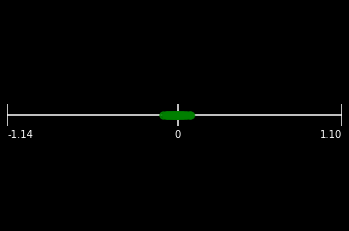

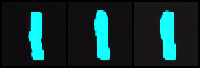

22
Dimension 22 	mean 0.01 	var 0.78


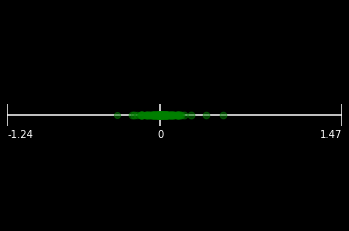

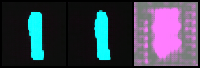

23
Dimension 23 	mean 0.00 	var 0.76


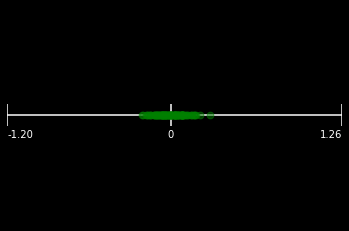

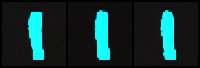

24
Dimension 24 	mean 0.00 	var 0.77


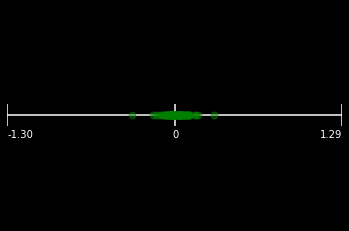

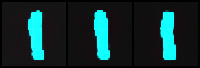

25
Dimension 25 	mean -0.01 	var 0.77


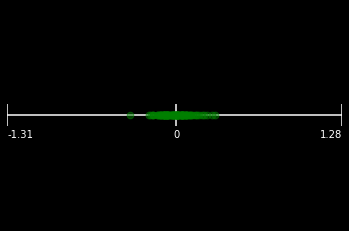

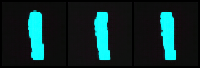

26
Dimension 26 	mean 0.00 	var 0.78


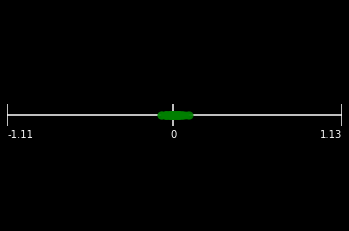

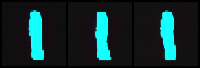

27
Dimension 27 	mean -0.00 	var 0.78


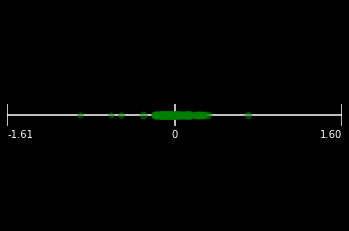

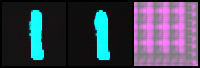

28
Dimension 28 	mean 0.00 	var 0.79


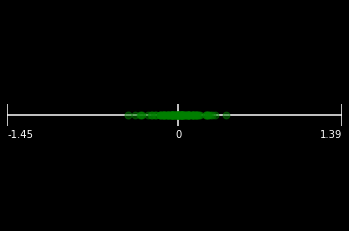

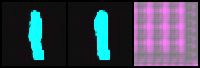

29
Dimension 29 	mean 0.00 	var 0.79


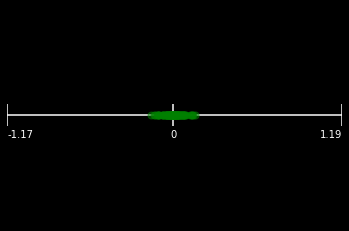

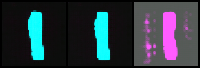

30
Dimension 30 	mean 0.00 	var 0.77


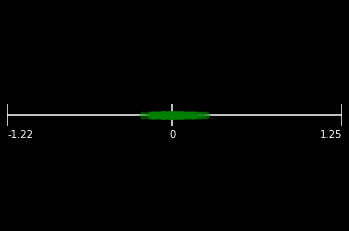

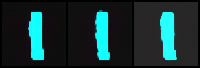

31
Dimension 31 	mean 0.00 	var 0.78


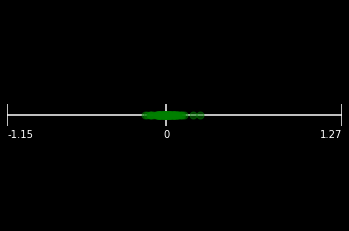

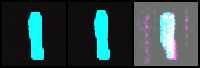

32
Dimension 32 	mean -0.00 	var 0.78


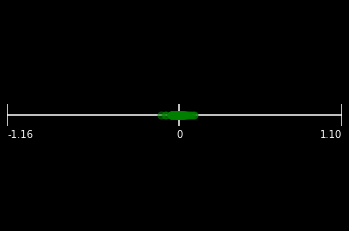

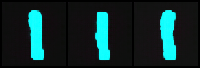

33
Dimension 33 	mean -0.00 	var 0.79


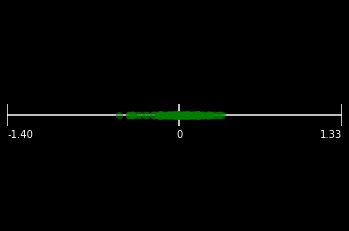

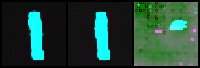

34
Dimension 34 	mean 0.00 	var 0.78


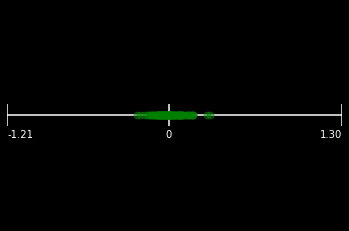

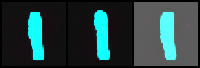

35
Dimension 35 	mean 0.14 	var 0.75


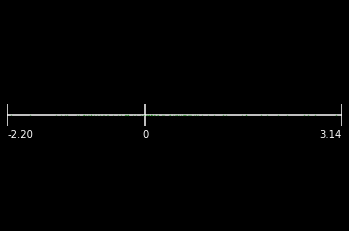

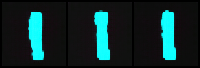

36
Dimension 36 	mean 0.01 	var 0.77


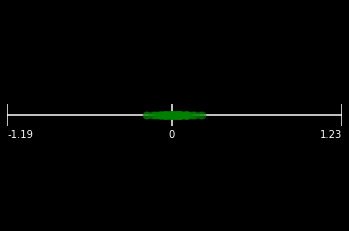

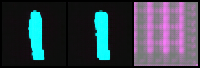

37
Dimension 37 	mean 0.00 	var 0.79


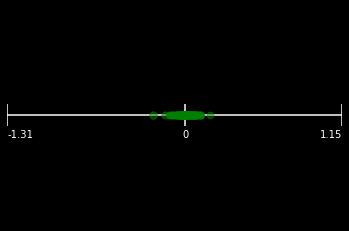

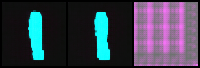

38
Dimension 38 	mean 0.02 	var 0.77


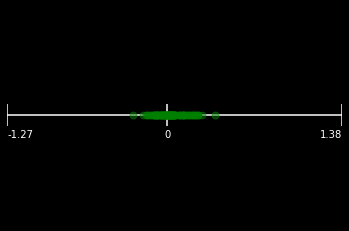

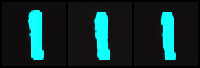

39
Dimension 39 	mean -0.03 	var 0.78


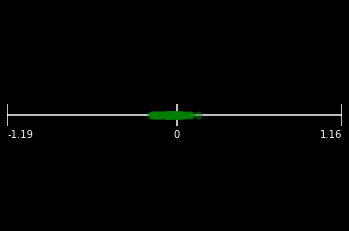

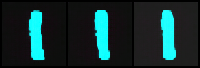

40
Dimension 40 	mean 0.00 	var 0.78


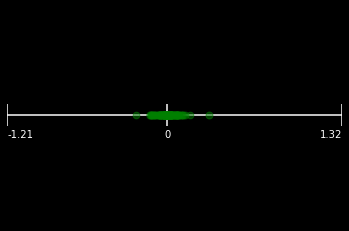

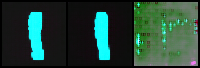

41
Dimension 41 	mean 0.00 	var 0.75


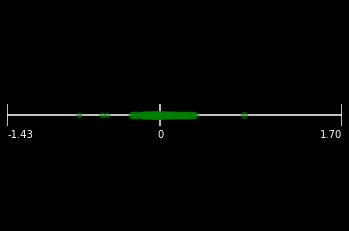

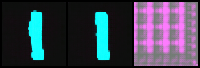

42
Dimension 42 	mean -0.05 	var 0.99


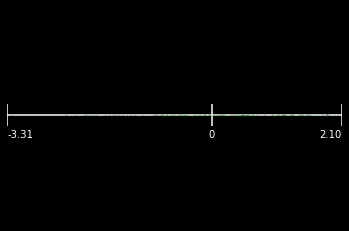

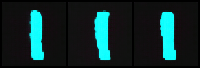

43
Dimension 43 	mean 0.01 	var 0.77


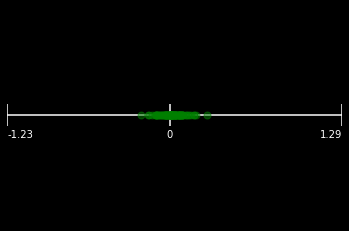

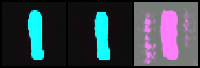

44
Dimension 44 	mean -0.00 	var 0.78


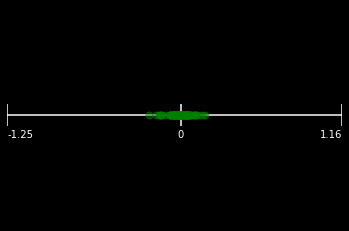

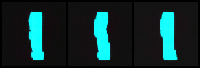

45
Dimension 45 	mean -0.03 	var 0.77


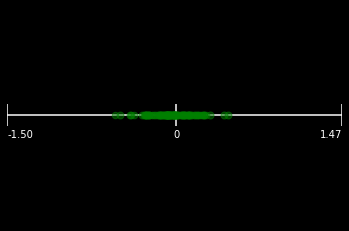

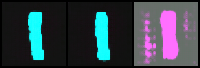

46
Dimension 46 	mean -0.01 	var 0.79


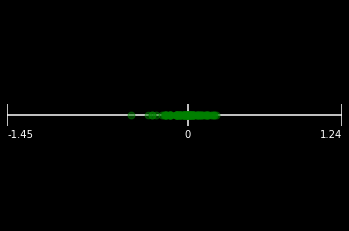

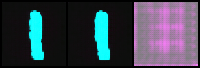

47
Dimension 47 	mean -0.01 	var 0.78


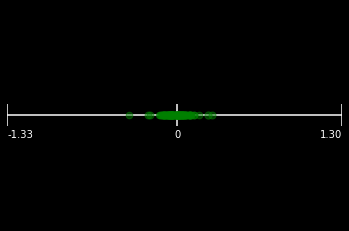

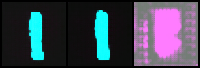

48
Dimension 48 	mean 0.01 	var 0.78


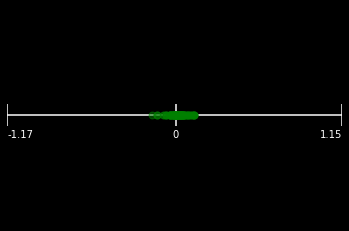

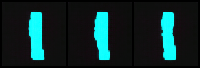

49
Dimension 49 	mean -0.03 	var 0.70


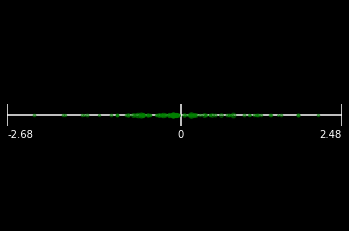

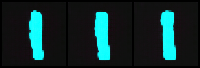

50
Dimension 50 	mean -0.01 	var 0.77


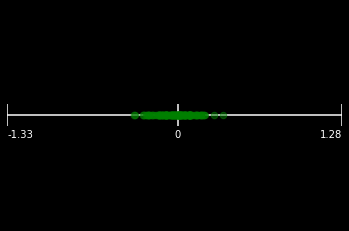

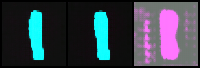

51
Dimension 51 	mean 0.00 	var 0.78


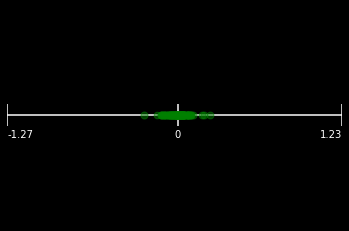

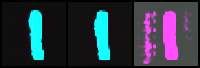

52
Dimension 52 	mean 0.00 	var 0.80


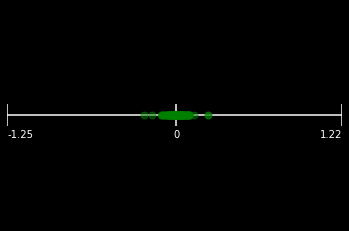

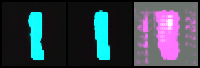

53
Dimension 53 	mean -0.00 	var 0.77


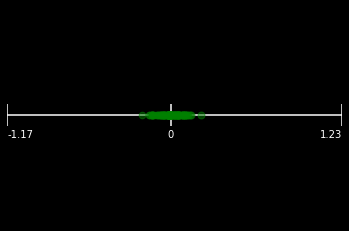

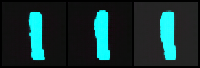

54
Dimension 54 	mean -0.08 	var 0.83


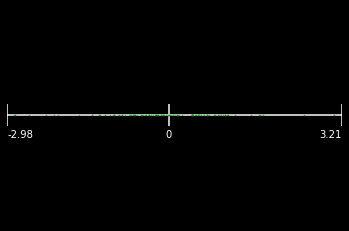

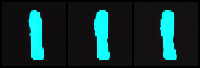

55
Dimension 55 	mean 0.00 	var 0.78


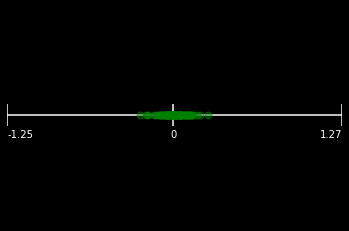

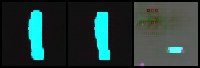

56
Dimension 56 	mean -0.00 	var 0.79


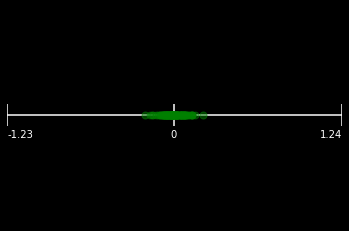

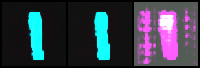

57
Dimension 57 	mean -0.01 	var 0.79


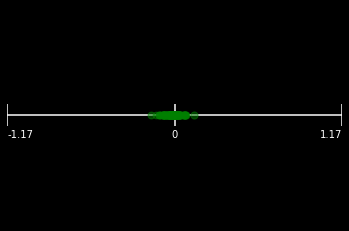

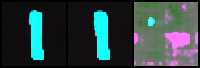

58
Dimension 58 	mean 0.02 	var 0.76


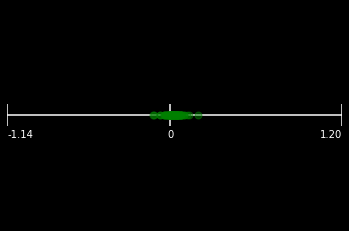

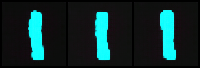

59
Dimension 59 	mean 0.01 	var 0.79


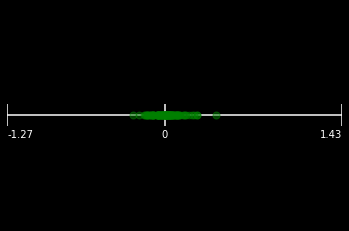

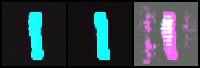

60
Dimension 60 	mean 0.01 	var 0.77


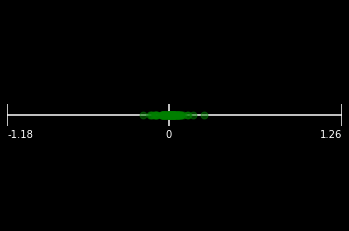

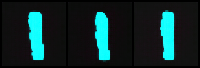

61
Dimension 61 	mean 0.01 	var 0.77


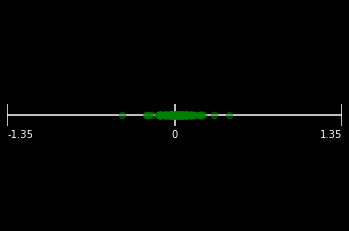

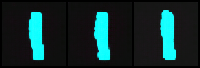

62
Dimension 62 	mean 0.00 	var 0.79


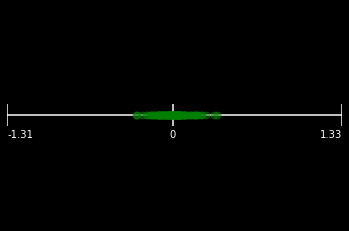

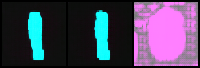

63
Dimension 63 	mean 0.02 	var 0.78


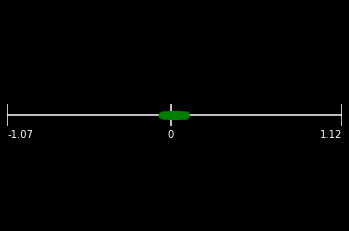

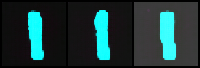

64
Dimension 64 	mean -0.01 	var 0.78


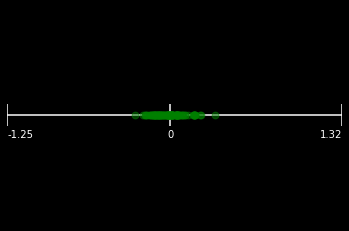

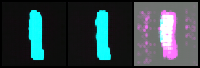

65
Dimension 65 	mean -0.00 	var 0.78


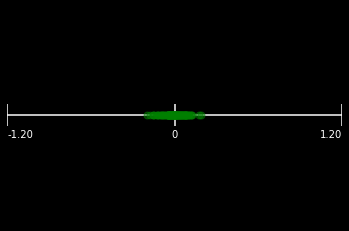

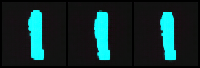

66
Dimension 66 	mean 0.03 	var 0.78


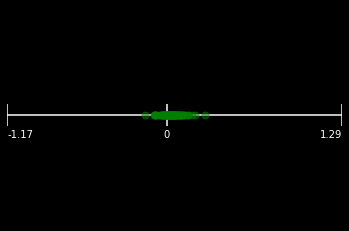

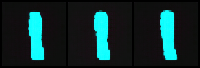

67
Dimension 67 	mean 0.01 	var 0.78


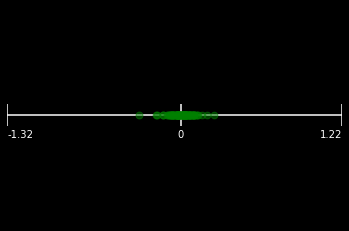

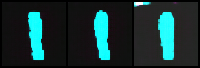

68
Dimension 68 	mean -0.01 	var 0.76


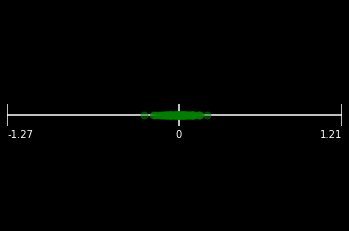

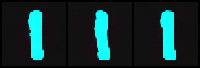

69
Dimension 69 	mean -0.01 	var 0.78


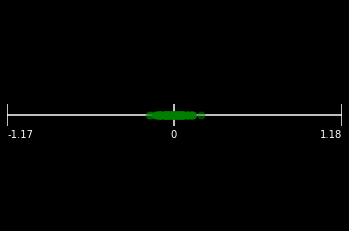

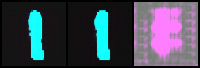

70
Dimension 70 	mean 0.04 	var 0.70


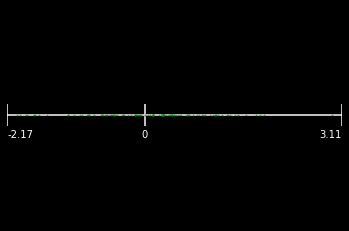

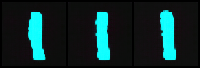

71
Dimension 71 	mean -0.01 	var 0.77


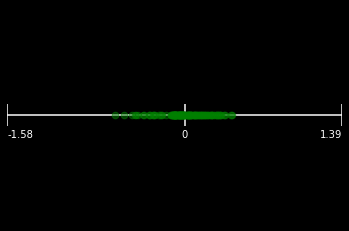

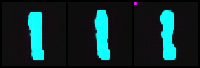

72
Dimension 72 	mean -0.01 	var 0.78


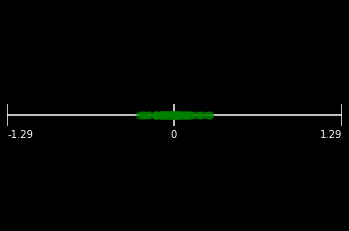

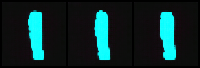

73
Dimension 73 	mean 0.00 	var 0.77


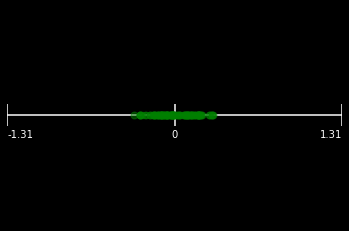

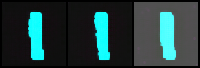

74
Dimension 74 	mean 0.01 	var 0.75


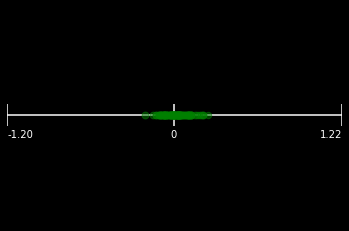

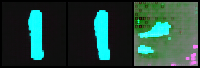

75
Dimension 75 	mean 0.01 	var 0.78


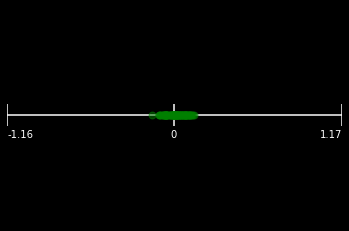

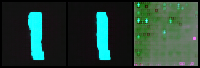

76
Dimension 76 	mean 0.01 	var 0.78


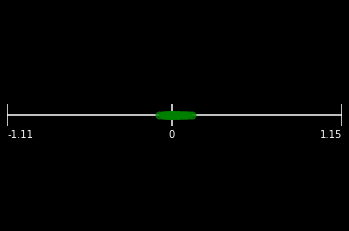

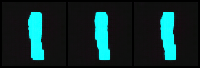

77
Dimension 77 	mean 0.01 	var 0.79


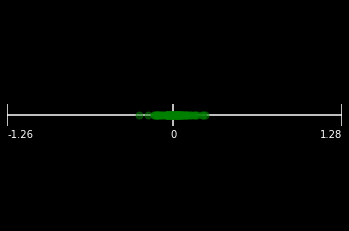

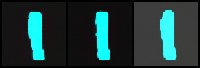

78
Dimension 78 	mean 0.01 	var 0.79


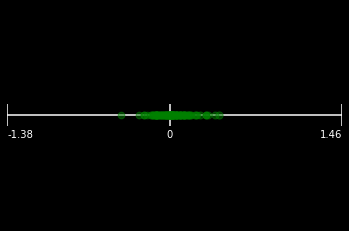

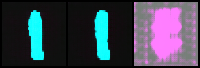

79
Dimension 79 	mean 0.00 	var 0.79


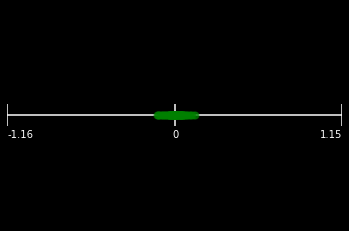

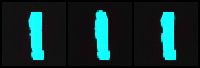

80
Dimension 80 	mean 0.00 	var 0.78


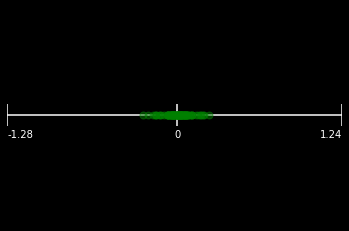

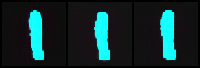

81
Dimension 81 	mean 0.10 	var 0.59


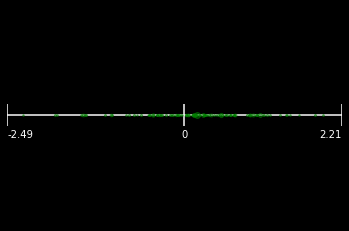

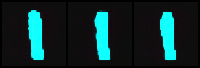

82
Dimension 82 	mean -0.00 	var 0.77


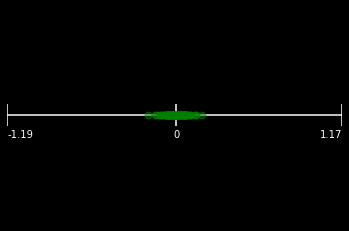

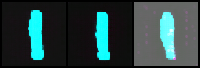

83
Dimension 83 	mean -0.02 	var 0.79


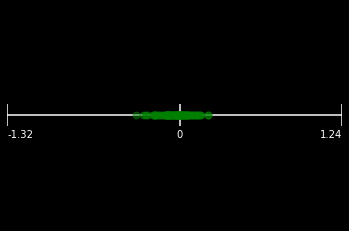

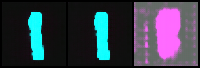

84
Dimension 84 	mean -0.01 	var 0.77


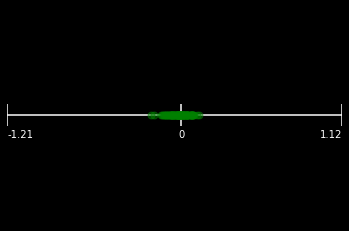

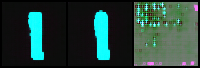

85
Dimension 85 	mean 0.01 	var 0.78


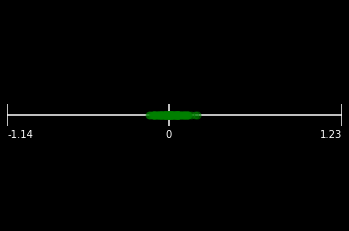

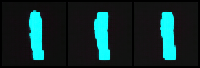

86
Dimension 86 	mean 0.00 	var 0.78


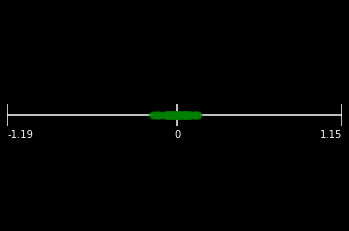

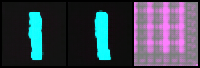

87
Dimension 87 	mean -0.02 	var 0.76


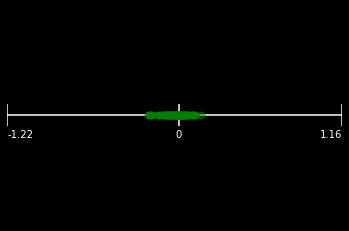

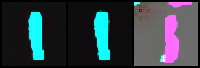

88
Dimension 88 	mean -0.00 	var 0.76


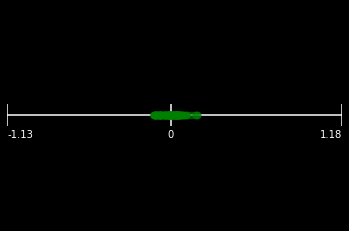

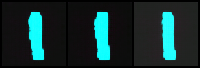

89
Dimension 89 	mean -0.01 	var 0.79


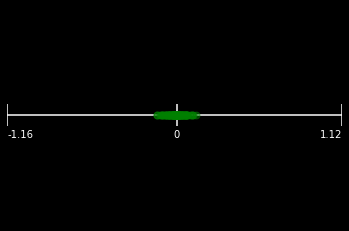

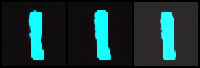

90
Dimension 90 	mean 0.02 	var 0.79


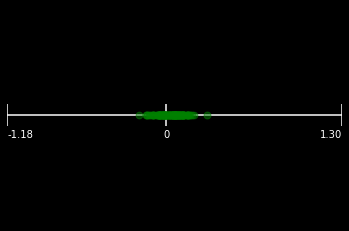

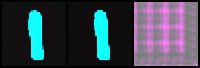

91
Dimension 91 	mean 0.02 	var 0.78


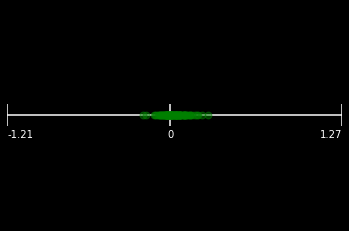

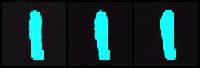

92
Dimension 92 	mean -0.00 	var 0.78


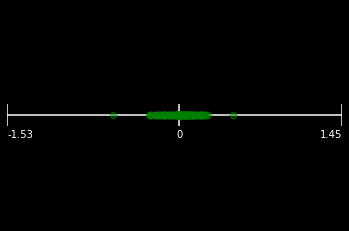

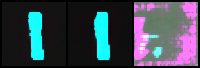

93
Dimension 93 	mean 0.01 	var 0.79


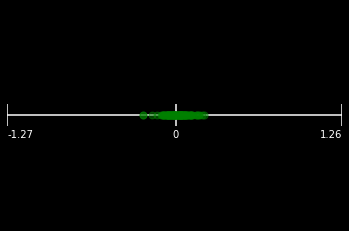

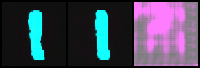

94
Dimension 94 	mean 0.00 	var 0.77


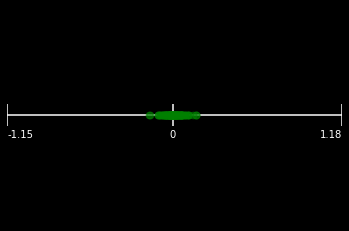

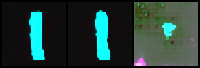

95
Dimension 95 	mean -0.00 	var 0.78


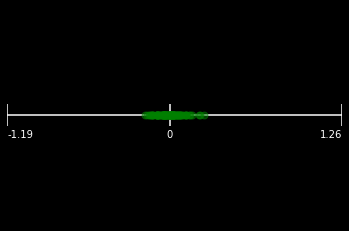

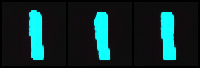

96
Dimension 96 	mean 0.01 	var 0.77


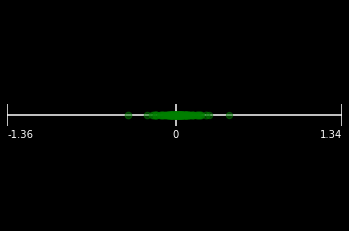

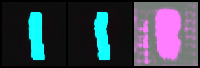

97
Dimension 97 	mean 0.01 	var 0.77


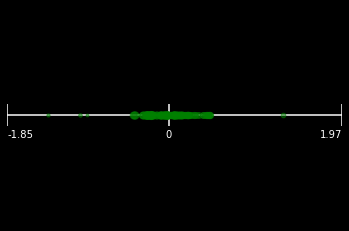

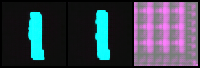

98
Dimension 98 	mean 0.02 	var 0.78


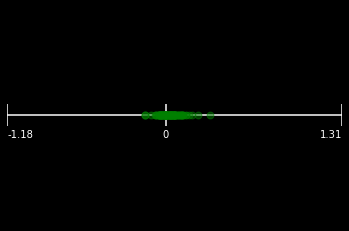

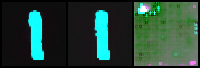

99
Dimension 99 	mean 0.00 	var 0.79


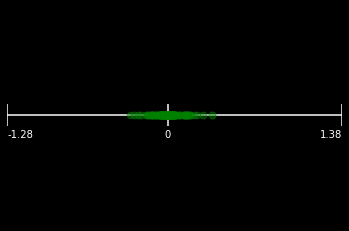

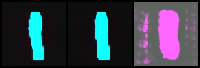

100
Dimension 100 	mean 0.02 	var 0.76


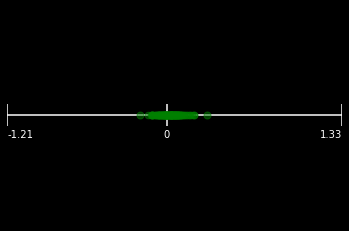

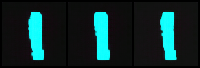

101
Dimension 101 	mean 0.02 	var 0.78


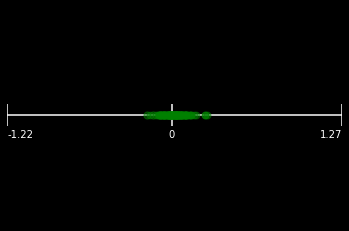

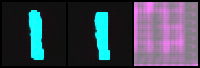

102
Dimension 102 	mean 0.01 	var 0.78


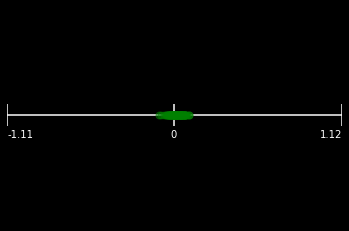

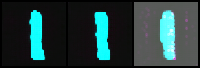

103
Dimension 103 	mean 0.02 	var 0.78


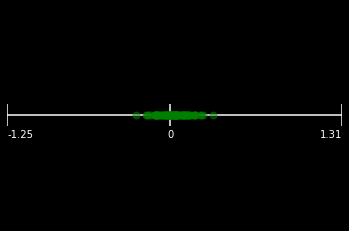

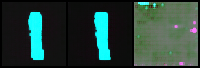

104
Dimension 104 	mean 0.01 	var 0.81


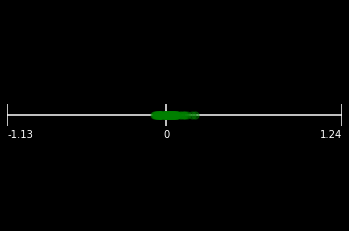

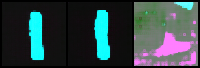

105
Dimension 105 	mean 0.02 	var 0.80


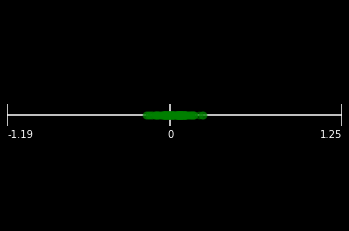

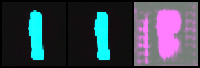

106
Dimension 106 	mean 0.15 	var 0.63


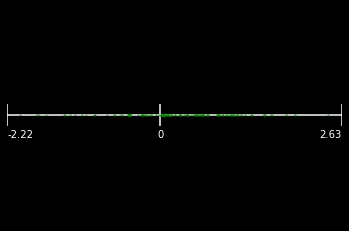

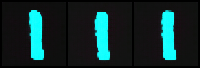

107
Dimension 107 	mean 0.01 	var 0.78


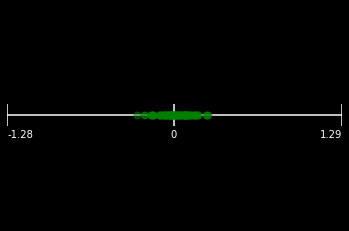

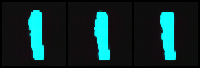

108
Dimension 108 	mean -0.01 	var 0.79


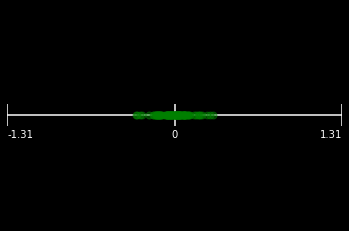

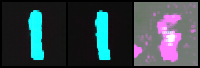

109
Dimension 109 	mean 0.01 	var 0.76


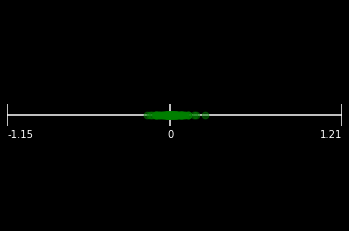

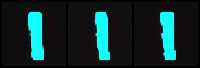

110
Dimension 110 	mean 0.00 	var 0.77


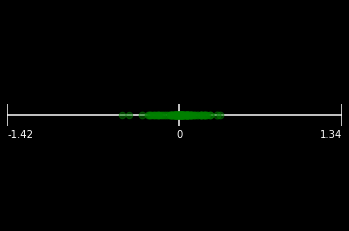

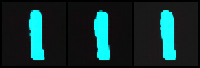

111
Dimension 111 	mean -0.00 	var 0.80


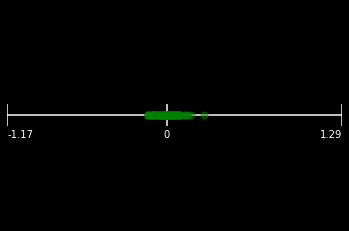

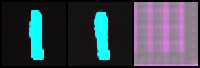

112
Dimension 112 	mean 0.01 	var 0.77


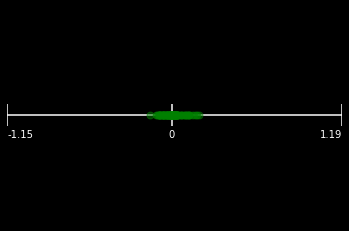

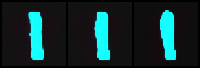

113
Dimension 113 	mean -0.01 	var 0.78


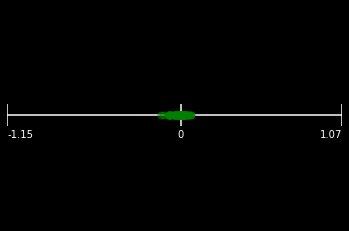

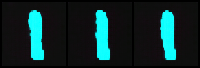

114
Dimension 114 	mean 0.00 	var 0.79


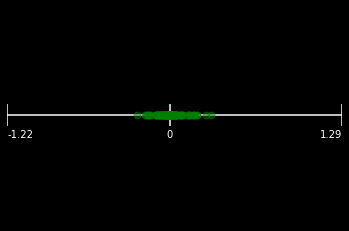

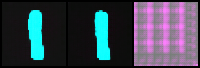

115
Dimension 115 	mean 0.02 	var 0.77


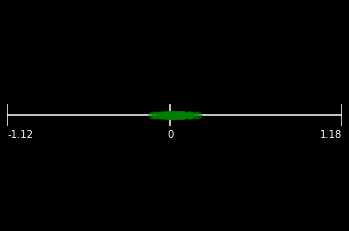

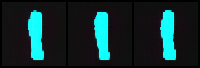

116
Dimension 116 	mean 0.01 	var 0.79


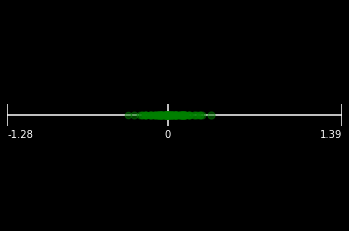

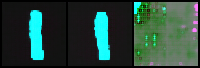

117
Dimension 117 	mean 0.02 	var 0.78


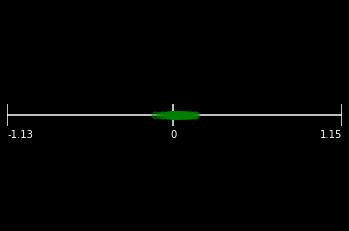

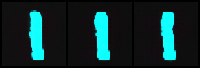

118
Dimension 118 	mean -0.03 	var 0.78


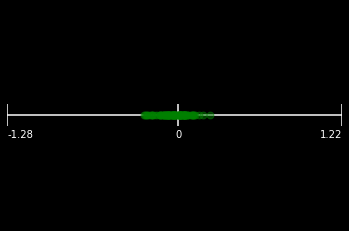

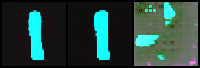

119
Dimension 119 	mean -0.08 	var 1.15


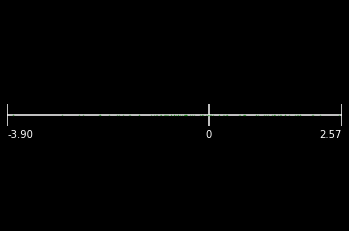

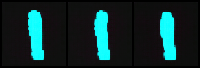

120
Dimension 120 	mean 0.01 	var 0.79


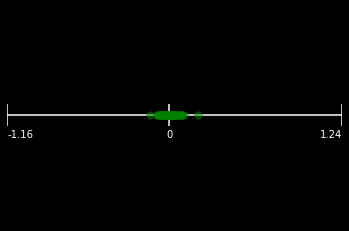

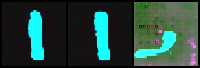

121
Dimension 121 	mean 0.03 	var 0.76


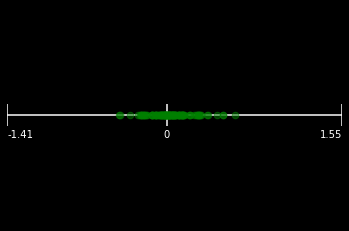

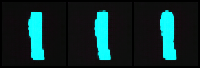

122
Dimension 122 	mean 0.01 	var 0.77


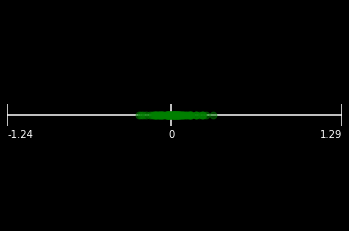

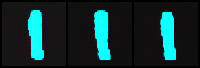

123
Dimension 123 	mean 0.02 	var 0.78


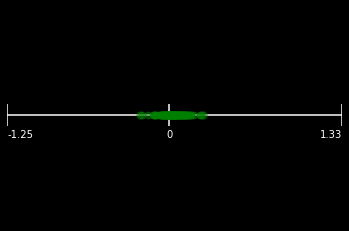

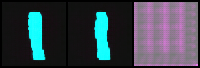

124
Dimension 124 	mean 0.00 	var 0.77


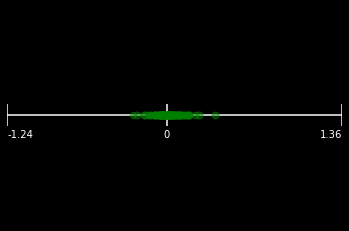

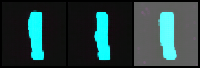

125
Dimension 125 	mean 0.01 	var 0.76


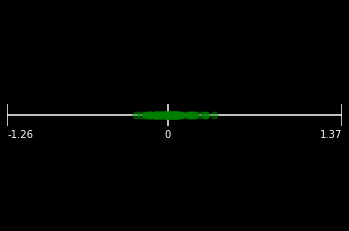

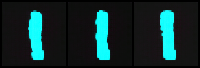

126
Dimension 126 	mean 0.02 	var 0.80


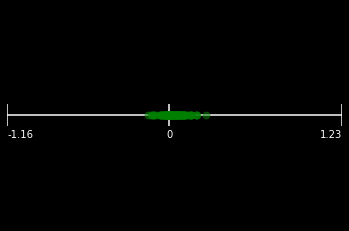

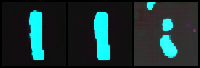

127
Dimension 127 	mean -0.00 	var 0.78


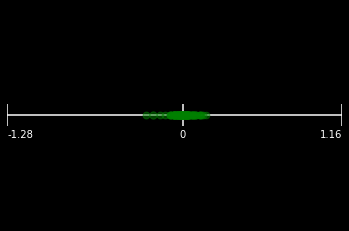

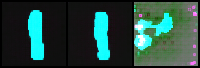

In [30]:
D=mu.shape[1]
dmeans = []
dstdevs = []
for d in range(D):
    print(d)
    mean = mu[:,d].sum()/D #mixture distribution
    stdev = (var[:,d] + mu[:,d]**2).sum()/D - mean**2
    print('Dimension', d, '\tmean %.2f'%mean, '\tvar %.2f'%stdev)
    graph(mu[:,d], var[:,d])
    dmeans.append(mean)
    dstdevs.append(stdev)

    o, i, bmu, blogvar = model.forward(imgs.cuda())
    o = normalize(o)[index].squeeze()

    mup = bmu
    mup[:,d] = mup[:,d] + math.e**(factor*blogvar[:,d])
    op = model.decode(model.reparameterize(mup, blogvar))
    op = normalize(op)[index].squeeze()

    mum = bmu
    mum[:,d] = mum[:,d] - math.e**(factor*blogvar[:,d])
    om = model.decode(model.reparameterize(mum, blogvar))
    om = normalize(om)[index].squeeze()

    grid = make_grid([om, o, op])
    display(pil()(grid))

Mean and stdev tend to be about 0 and 1?

In [31]:
sum(dmeans)/D

0.0036264528951051034

In [32]:
sum(dstdevs)/D

0.7790757459972392

Ideas
- Measure "normalness" of the distribution
- How much are these graphs varying across different selections of n points
- What does it mean if the distribution is less centered around 0? More outliers to 1 side, lower/higher stdev, skewness, etc
- Compare shape of dimension's distribution for train vs val set
- How does all this change with different quantities of data and numbers of latent dimensions
- Over course of training, hypothesis that mean and stdev for each dimension tend to tend closer to 0 and 1 respectively
- For betavae: find a dimension corresponding to some underrepresented attribute and see how it differs from one corresponding to a well-represented attribute